In [9]:
# %matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colormaps


from astropy.io import fits
from IPython.display import HTML
from hcipy import *

import sys
# sys.path.append('/home/jliberman/github_repos/magaox-iefc-sim/')
sys.path.append('/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/')


from iefc_utils import *

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)


# from magsimpyx import make_magaox_bump_mask   # TODO: Get magsimpyx import to work

PLOT_DIR = '/home/jasper/Documents/HCIPy_scripts/magaox-iefc-sim/FPM_shift/'

# plt.style.use('spieposter')
# PLOT_DIR = '/home/jliberman/github_repos/magaox-iefc-sim/DM_shift/'

# /home/jliberman/github_repos/magaox-iefc-sim/Lyot_shift/Images



        


In [10]:
# Set units

magnification_factor = (9*1e-3)/6.5
pupil_diameter = 6.5
# effective_focal_length = 71.5 
wavelength = 750e-9 # m
effective_focal_length = 1

spatial_resolution = wavelength / pupil_diameter
sr = spatial_resolution

# Set up pupil/focal grids
# mpl.rcParams['figure.dpi'] = 100


pupil_grid = make_pupil_grid(512, diameter=3*pupil_diameter)    # Pad the grid to offer a bit more room
# pupil_grid = make_pupil_grid(256, diameter=pupil_diameter)
focal_grid = make_focal_grid(q=5, num_airy=25, spatial_resolution = wavelength/pupil_diameter)
# Create CG focal grid to oversample CG
coro_focal_grid = make_focal_grid(q=32, num_airy=4, spatial_resolution = wavelength/pupil_diameter)
prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=effective_focal_length)


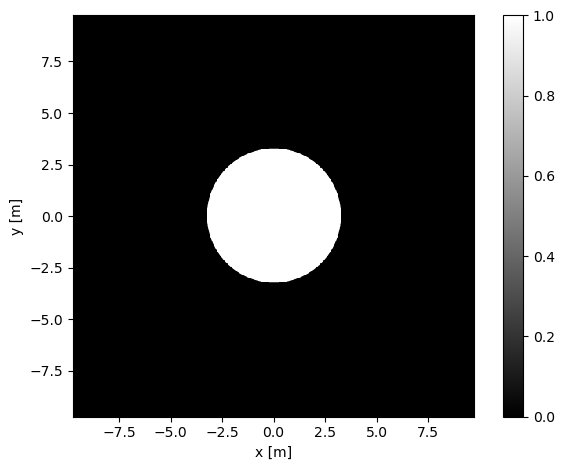

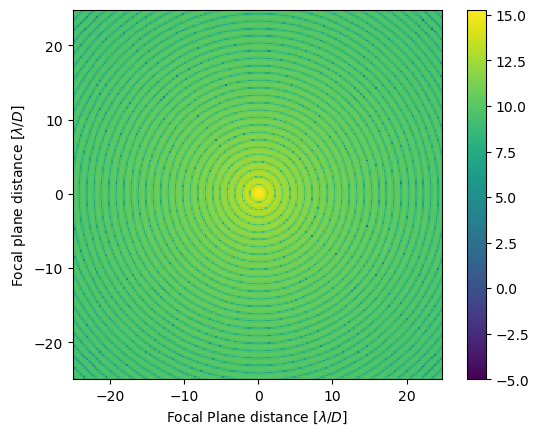

In [11]:
# Plot the bump mask scaled up to MagAO-X pupil diameter

# offset = 0.0
# bump_mask_offset = [offset*pupil_diameter, 0]


# Plot the bump mask scaled up to MagAO-X pupil diameter

telescope_pupil_circ =evaluate_supersampled(make_circular_aperture(pupil_diameter), pupil_grid, 4)

# telescope_pupil_mag = evaluate_supersampled(make_rotated_aperture(make_magaox_bump_mask(), np.pi/2), pupil_grid, 4)


# Plot telescope  pupil
imshow_field(telescope_pupil_circ, cmap='gray',)
plt.colorbar()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.tight_layout()
# plt.savefig('../mag_ap.svg', transparent=True)
plt.show()

wavefront = Wavefront(telescope_pupil_circ, wavelength)

focal_image = prop.forward(wavefront)

norm = focal_image.power.max()

# Plot PSF
imshow_field(np.log10(focal_image.intensity / norm), vmin=-5, grid_units=sr)
# save_field('magellan_pup.svg', np.log10(focal_image.intensity / norm))
plt.xlabel('Focal Plane distance [$\lambda / D$]')
plt.ylabel('Focal plane distance [$\lambda / D$]')
plt.colorbar()
plt.show()


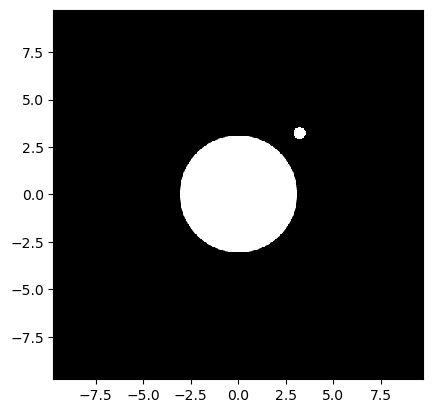

In [12]:
     # Generate slightly undersized Lyot Stop                   
lyot_mask = evaluate_supersampled(make_circular_aperture(0.95*pupil_diameter), pupil_grid, 4)

pinhole_diameter = 0.5742e-3 # TODO: Ask about this...

# Add pinhole to Lyot mask 
pinhole_pos = .7 * np.array([pupil_diameter/np.sqrt(2), pupil_diameter/np.sqrt(2)])
pinhole = make_circular_aperture(0.1*pupil_diameter, center=pinhole_pos)

scc_mask = lyot_mask * (1-pinhole(pupil_grid)) + pinhole(pupil_grid)
imshow_field(scc_mask, cmap='gray')
plt.show()

scc_stop = Apodizer(scc_mask)

lyot_stop = Apodizer(lyot_mask)


In [13]:
############ Initialize VVC
charge = 6                      # Generate a charge 6 Vortex CG
coro_vortex = VectorVortexCoronagraph(charge, lyot_stop=scc_stop)

In [20]:
optical_system_vort_scc = OpticalSystem([coro_vortex, scc_stop, prop])
optical_system_vort = OpticalSystem([coro_vortex, lyot_stop, prop])

wf_vortex = Wavefront(telescope_pupil_circ, wavelength)


sa = SurfaceAberration(pupil_grid, 0.1*wavelength, pupil_diameter)


# norm = optical_system_vortex(wf_vortex).intensity.max()

# wfout = prop(optical_system_vortex(wf_vortex))

/home/jliberman/anaconda3/envs/hcipy-env-2/lib/python3.10/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [16]:
wf_coronagraph_ab = coro_vortex(sa(wf_vortex))

wf_lyot = lyot_stop(wf_coronagraph_ab)

img_lyot = prop(wf_lyot).power

wf_scc = scc_stop(wf_coronagraph_ab)
img_scc = prop(wf_scc).power

# psf_scc = optical_system_vortex()


In [21]:
img_scc = optical_system_vort_scc(sa(wf_vortex)).power
img_lyot = optical_system_vort(sa(wf_vortex)).power

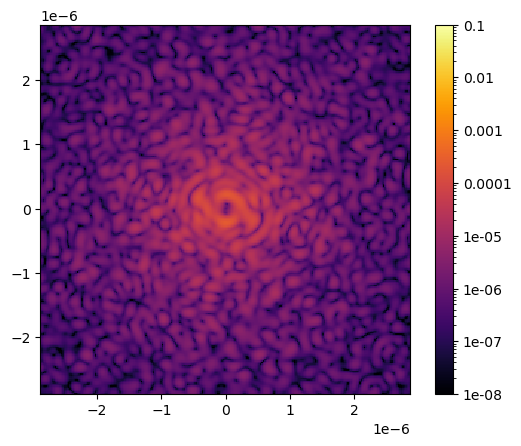

In [22]:
# imshow_field(np.log10(optical_system_vortex(wf_vortex).intensity / norm), grid_units=sr)


imshow_psf(img_lyot / norm)
plt.show()

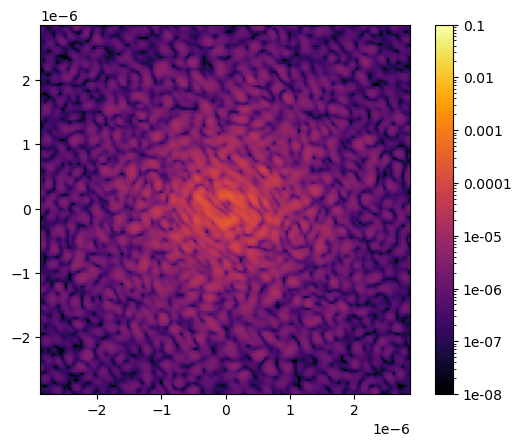

In [23]:
imshow_psf(img_scc / norm)

In [10]:
# Shift the MTF in x and y such that one of the sidebands is centered

img_lyot_shifted = img_lyot * (np.exp(2j * np.pi * focal_grid.x * pinhole_pos[0]/wavelength) 
                            * np.exp(2j * np.pi * focal_grid.y * pinhole_pos[1]/wavelength))


# wf_scc_shifted = Wavefront(img_scc * (np.exp(2j * np.pi * focal_grid.x * pinhole_pos[0]) 
                            # * np.exp(2j * np.pi * focal_grid.y * pinhole_pos[1])))

img_scc_shifted = img_scc * (np.exp(2j * np.pi * focal_grid.x * pinhole_pos[0]/wavelength) 
                            * np.exp(2j * np.pi * focal_grid.y * pinhole_pos[1]/wavelength))



In [11]:
fft = FastFourierTransform(focal_grid)

In [12]:
otf_scc = fft.forward(img_scc)
otf_scc_shifted = fft.forward(img_scc_shifted)

otf_lyot = fft.forward(img_lyot)
otf_lyot_shifted = fft.forward(img_lyot_shifted)


mtf_lyot = np.abs(otf_lyot)
mtf_lyot_shifted = np.abs(otf_lyot_shifted)

mtf_scc = np.abs(otf_scc)
mtf_scc_shifted = np.abs(otf_scc_shifted)

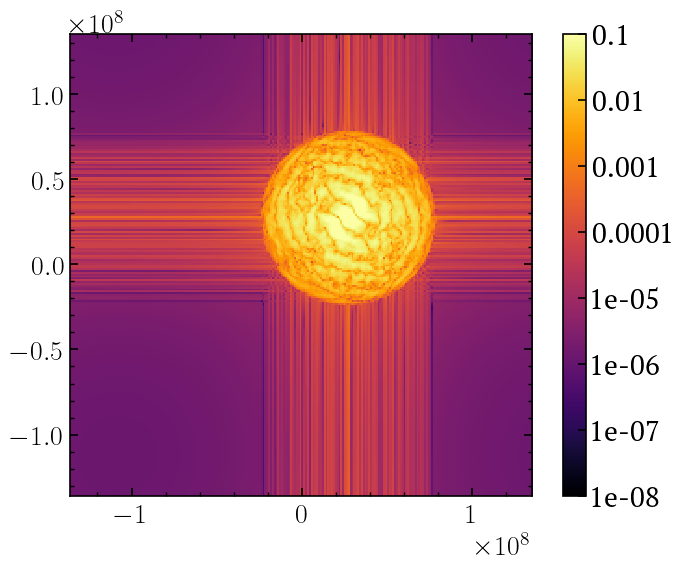

In [13]:
imshow_psf(mtf_lyot_shifted / mtf_lyot_shifted.max())

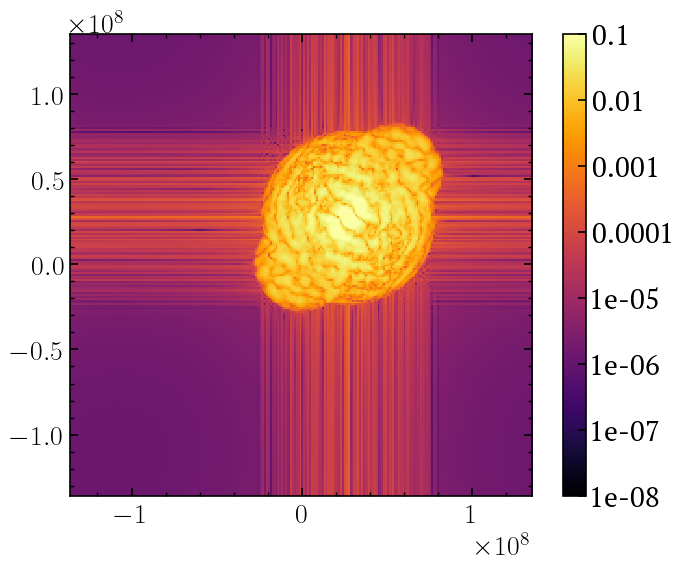

In [14]:
imshow_psf(mtf_scc_shifted / mtf_scc_shifted.max())

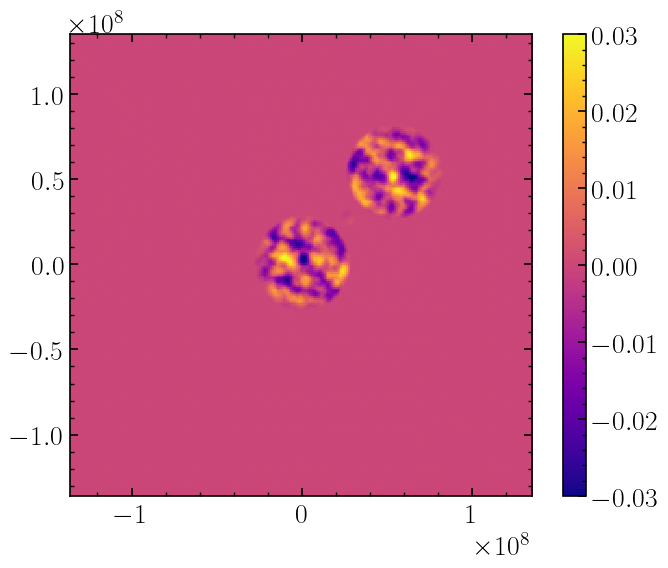

In [15]:
diff_im = otf_scc - otf_lyot

diff_im_shifted = otf_scc_shifted - otf_lyot_shifted

imshow_field(np.imag(diff_im_shifted) / mtf_scc_shifted.max(), vmax=0.03, vmin=-0.03) # Look at amplitude of OTF
plt.colorbar()

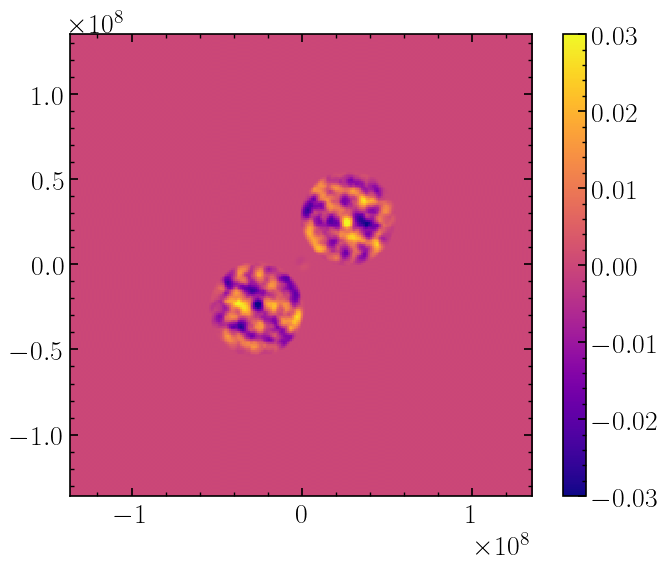

In [16]:
# Sidebands are the convolution of the pinhole w/ the aperture

imshow_field(np.imag(diff_im) / mtf_scc.max(), vmax=0.03, vmin=-0.03) # Look at phase of OTF
plt.colorbar()

In [17]:
fft_grid = make_fft_grid(focal_grid)
# center=np.array([0.4e8, 0.3e8])
# Define circular mask on FFT grid


In [29]:
fft_scaled_grid = fft_grid.scaled(wavelength/(2*np.pi)) # Convert back to meters

In [30]:
aperture = make_circular_aperture(pupil_diameter)(fft_scaled_grid)

In [32]:
pupil_diameter

6.5

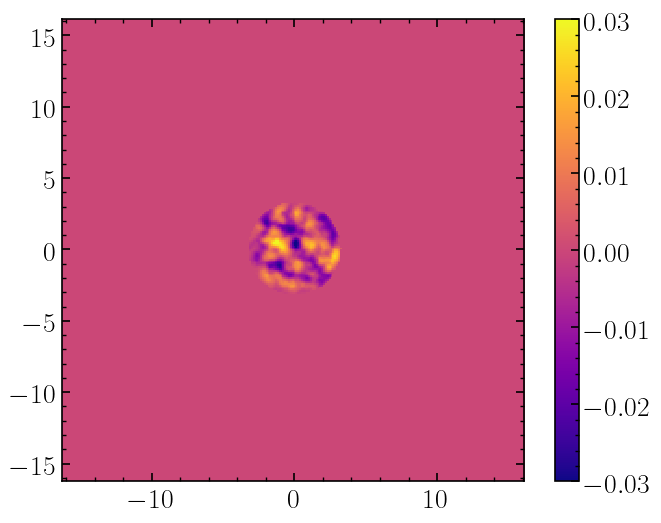

In [31]:
# Multiply mask by OTF to obtain single sideband
imshow_field((np.imag(diff_im_shifted)* aperture) / mtf_scc.max() , fft_scaled_grid, vmax=0.03, vmin=-0.03) 
plt.colorbar()

In [33]:
# Extract single, centered sideband
sideband = diff_im_shifted*aperture

In [36]:
print(sideband.grid.delta)

[1089085.45324446 1089085.45324446]


In [37]:
sideband_psf = fft.backward(sideband)

In [41]:
sideband_psf.grid.delta

array([2.30769231e-08, 2.30769231e-08])

In [42]:
sr

1.1538461538461539e-07

In [38]:
# Apply opposite tilt in FP
# sideband_psf = sideband_psf * (np.exp(-(2j * np.pi * focal_grid.x * pinhole_pos[0]/wavelength)) 
#                             * np.exp(-(2j * np.pi * focal_grid.y * pinhole_pos[1]/wavelength)))

In [39]:
# Convert back to units in position space (TODO: Check this because I'm not sure if it's right)
# sideband_psf = sideband_psf * wavelength

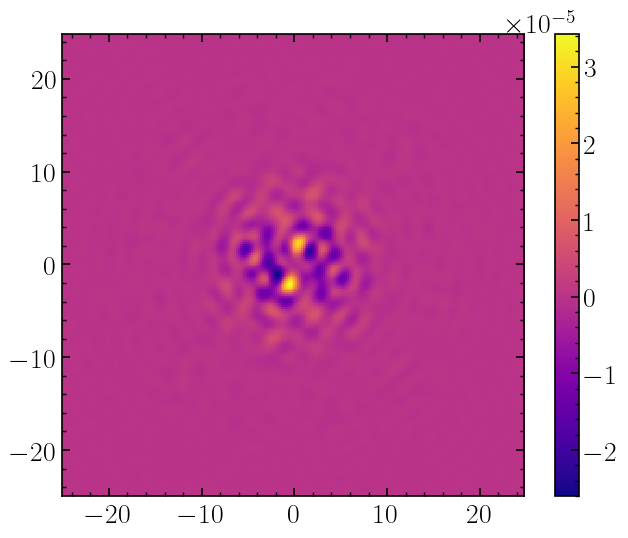

In [46]:
imshow_field(np.imag(sideband_psf)/ norm, grid_units=sr)
plt.colorbar()

# imshow_psf(sideband_psf / norm)

In [ ]:
# sideband_psf / 

In [47]:
sideband_psf_arr_imag = np.array(np.imag(sideband_psf))

In [48]:
# Construct masked array w/o zeros
# sideband_psf_arr_imag = sideband_psf_arr_imag[sideband_psf_arr_imag!=0]

# sideband_psf_arr_imag = np.ma.masked_equal(sideband_psf_arr_imag, 0)

In [50]:
sideband_psf_arr_imag.std()

1.9074758481872413e-06

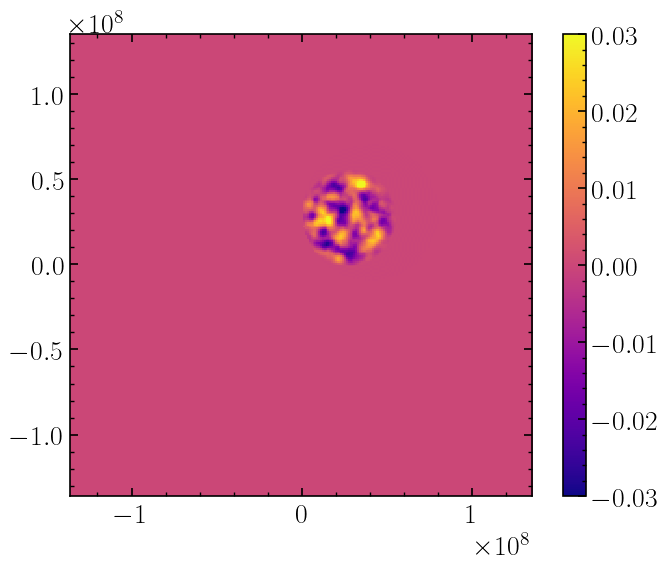

In [61]:
imshow_field(np.imag(sideband) / mtf_scc.max() , vmax=0.03, vmin=-0.03) # Look at phase of OTF
plt.colorbar()

In [62]:
# Extract single sideband and perform ifft
# Note that one of the sidebands 
sideband_psf = fft.backward(sideband)


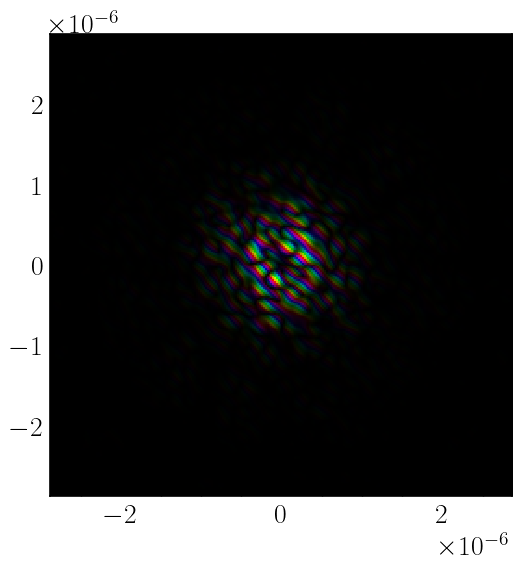

In [64]:
imshow_field(sideband_psf/norm)